In [1]:
from __future__ import division, print_function
import numpy as np
from trial import Trial
from dataPoint import DataPoint
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from pomdp import POMDP
from discretePomdp import DiscretePOMDP
from continuousPomdp import ContinuousPOMDP
from pomdpWithCostSz import POMDPWithCostSz
from pomdpWithBound import POMDPWithBound
from histPomdp import HistPOMDP
from knownCPomdp import KnownCPOMDP
#from fit import Fit
from analysis import Analysis
from environment import Environment
import copy
from fit import Fit
%matplotlib inline

[0, 16, 32, 64, 128, 256, 512]


# General Parameters

In [2]:
num_samples = 20000
std_z = 1.0
num_quantiles = 10
step_time = 10
mu_i = 0.0
num_bins =200

# Monkey-specific Parameters

In [3]:
### Monkey 1
monkey = 2
if monkey == 1:
    std_i = .45 #.45 #.29
    std_i2 = .29
    std_z_s = 1.6 #1.6 #1.42
    k = 1.
    std_z = .90
    threshold_s = .63
    k_cost = 1.2
    cost = 10 ** -11
    cost_low = 2 * 10 ** -8
    th_low = .81
    cost_high = 2 * 10 ** -5
    th_high = .717
    all_trials = Trial.readFile('beh_data.monkey1.mat')
    y_color = 'black'
else: #monkey2
    k =  1
    std_z = 1.69
    std_i = .87 #.87 #.43
    std_i2 = .43
    std_z_s = 3.59 #3.59 #2.81
    threshold_s = .59
    k_cost = .6
    th_low = .778
    th_high = .68
    cost_low = 10 ** -7
    cost_high = 2 * 10 ** -3
    cost = 10 ** -12
    all_trials = Trial.readFile('beh_data.monkey2.mat')
    y_color = 'white'

# Parameters of visualization

In [4]:
font = {'weight' : 'normal',
        'size'   : 36}
font2 = {'weight' : 'normal',
        'size'   : 27}
font3 = {'weight' : 'normal',
        'size'   : 32}
colors = ['red', 'blue', 'black', 'green', 'saddlebrown', 'indigo', 'm']

def setPlot():
    matplotlib.rc('font', **font)
    plt.title('M' + str(monkey), fontsize = 36)
    axes = plt.gca()
    figure = plt.gcf()
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.tick_params(top = False, right = False)
    axes.tick_params(direction='out', width = '2')
    figure.set_size_inches(8,8)
    plt.xlabel("Motion duration (ms)")
    plt.xlim([50, 710])

# Functions for visualization based on coherence and time

In [5]:
def analysisCoherence(a_r, ax, ax2, _color = 'gray', _label = 'Accuracy', _fmt = '-o', error = True, _edge_color = None):
    if _edge_color == None:
        _edge_color = _color
    cohs = np.array(sorted(a_r.keys()))
    all_acc = np.zeros(len(cohs))
    err_acc = np.zeros(len(cohs))
    for c, a_r_list in a_r.items():
        i = np.where(cohs == c)[0][0]
        num_trials = 0
        for a_r_point in a_r_list:
            num_trials += a_r_point.nrData
            err_acc[i] += a_r_point.performance *(1-a_r_point.performance)
            all_acc[i] += a_r_point.nrData * a_r_point.performance
        if num_trials > 0:
            err_acc[i] = err_acc[i] / float(num_trials)
            all_acc[i] = all_acc[i] / float(num_trials)
            
    cohs2 = np.array(sorted(a_r.keys()))
    cohs2 = cohs2[np.where(all_acc > 0)[0]]
    err_acc = err_acc[np.where (all_acc > 0)[0]]
    all_acc = all_acc[np.where (all_acc > 0)[0]]
    err_acc = err_acc ** .5
    if cohs2[0] == 0:
        cohs2[0] = 4    
    if error:
        ax.errorbar(cohs2, all_acc, fmt = _fmt, yerr= err_acc, label = _label, color = _color, linewidth = 3, markeredgecolor=_edge_color, markersize = 10, markeredgewidth = 3)
        ax2.errorbar(cohs2, all_acc, fmt = _fmt, yerr= err_acc, label = _label, color = _color, linewidth = 3, markeredgecolor=_edge_color, markersize = 10, markeredgewidth = 3)
    else:
        ax.plot(cohs2, all_acc, linestyle = _fmt, label = _label, color = _color, linewidth = 3, markeredgecolor=_edge_color, markersize = 10, markeredgewidth = 3)
        ax2.plot(cohs2, all_acc, linestyle = _fmt, label = _label, color = _color, linewidth = 3, markeredgecolor=_edge_color, markersize = 10, markeredgewidth = 3)
    
    ax.set_xscale('log')
    ax.minorticks_off()
    ax2.set_xscale('log')
    ax2.minorticks_off()

    ax.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.tick_params(labelleft= False)  
    ax.tick_params(top = False, right = False)
    ax2.tick_params(top = False, right = False, left = False)
    ax.tick_params(direction='out', width = '2')
    ax2.tick_params(direction='out', width = '2')

    ax.set_xticks([4])
    ax.set_xticklabels([0])

    ax.set_xlim([3, 7])
    ax2.set_xlim([8, 700])

    ax2.set_xticks([16, 64, 512])
    ax2.set_xticklabels([1.6, 6.4, 51.2])
    f.set_size_inches(8,8)
    d = .025  
    ratio = 6
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((1-ratio*.5*d, 1+ratio*.5*d), (-d, +d), **kwargs)        # top-left diagonal
    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-.5*d, +.5*d), (- d, + d), **kwargs)  # bottom-left diagonal
    f.subplots_adjust(wspace=.07)      
    plt.xlabel("Motion strength (%coh)")    
    #print (all_acc)
    return  

def analysisTime(a_r, _color = 'gray', _label = ['Accuracy'], _fmt = '-', error = True, _edge_color = None):
    if _edge_color == None:
        _edge_color = _color
    cohs = np.array(list(a_r.keys()))
    all_acc = np.zeros(num_quantiles)
    err_acc = np.zeros(num_quantiles)
    num_trials = np.zeros(num_quantiles)
    dur = np.zeros(num_quantiles)
    for c in cohs:
        t = 0
        for a_r_point in a_r[c]:
            num_trials[t] += a_r_point.nrData
            err_acc[t] += a_r_point.performance * (1-a_r_point.performance)
            all_acc[t] += a_r_point.nrData * a_r_point.performance
            dur[t] = a_r_point.avg_duration
            t = t + 1

    # remove 0 number trials (may happen in reaction time task)
    all_acc = all_acc[np.where(num_trials > 0)[0]]
    err_acc = err_acc[np.where(num_trials > 0)[0]]
    dur = dur[np.where(num_trials > 0)[0]]
    num_trials = num_trials[np.where(num_trials > 0)[0]]
    # normilize:
    all_acc = all_acc / num_trials
    err_acc = err_acc / num_trials
    err_acc = err_acc ** .5
    setPlot()
    if error:  
        plt.errorbar(dur, all_acc, fmt = _fmt, xerr = 0, yerr= err_acc, label = _label, color = _color, linewidth = 3, markeredgecolor = _edge_color, markersize = 10, markeredgewidth = 3)
    else:
        plt.plot(dur, all_acc, linestyle = _fmt, label = _label, color = _color, linewidth = 3, markeredgecolor=_edge_color, markersize = 10, markeredgewidth = 3)
    plt.gca().set_xticks([100, 300, 500, 700])
    return 

# Load Data

In [6]:
if monkey ==1:
    trials = all_trials
else:
    trials = []
    for trial in all_trials:
        if trial.coherence == 16:
            continue
        trials.append(trial)

# Real Data (Figure 1 except a)

Generate the data:

Accuracy thorugh trials 

([<matplotlib.axis.XTick at 0x7fe834ec2c40>,
 <a list of 3 Text major ticklabel objects>)

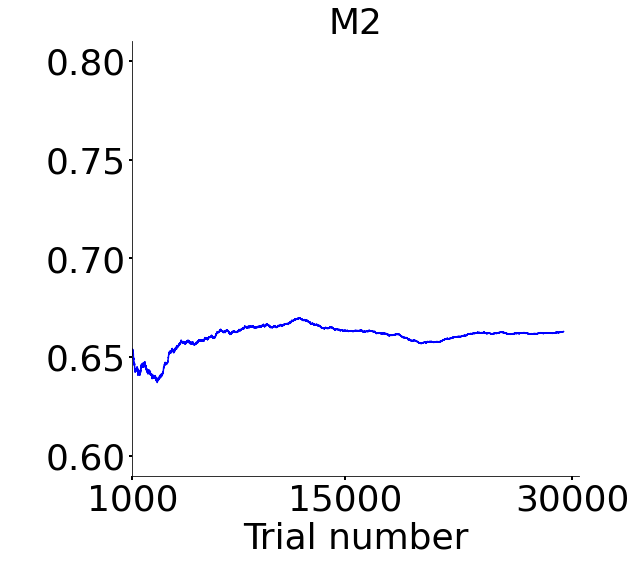

In [7]:
trials_sep_sure = Trial.seperateBySureShown(trials)
num_t = len(trials_sep_sure[False])
acc_trial = np.zeros(num_t + 1)
i = 0
for trial in trials_sep_sure[False]:
    i +=1
    acc_trial[i] = acc_trial[i-1] * (i-1) 
    if trial.getChoiceTarget()== trial.getCorrectTarget():
        acc_trial[i] +=1
    acc_trial[i] /= i

setPlot()
plt.plot(acc_trial[1000:], color = "blue")
plt.ylim([.59, .81])#[np.mean(acc_trial[1000:] -.10), np.mean(acc_trial[1000:]) + .10])
plt.xlabel("Trial number")
plt.ylabel("Accuracy",  color = y_color)
plt.xlim([1000, num_t +1])
plt.xticks([1000, 15000, 30000])

    
    

In [8]:
fit = Fit(1, step_time)
all_sds, all_sd_zs, all_sd_is = fit.findSdSubjectIter(trials_sep_sure[False], std_z, std_z_s)

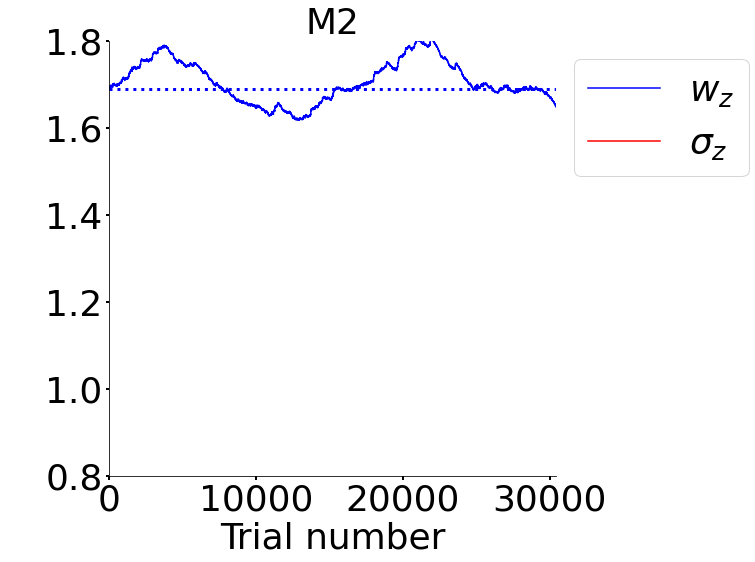

In [9]:
setPlot()
plt.plot(all_sds, color = "blue")
plt.plot(all_sd_zs, color = "red")
plt.ylim([.8, 1.8])
plt.xlim([0, all_sds.size + 1])
plt.xlabel("Trial number")
plt.ylabel("Free parameter", color = y_color)
plt.hlines(std_z_s, 0, 45000, lw = 3, linestyle ='dotted', color = "red")
plt.hlines(std_z, 0, 45000, lw = 3, linestyle ='dotted', color = "blue")

if monkey == 2:
    plt.legend([r'$w_z$', r'$\sigma_z$'], bbox_to_anchor=(1., 1), loc='upper left')

In [13]:
time_windows = Trial.sortAndDivideToQuantiles(trials, num_quantiles) 
trials_sep_sure = Trial.seperateBySureShown(trials)
trials_acc = Trial.seperateByCoherence(trials_sep_sure[False])
trials_sure = Trial.seperateByCoherence(trials_sep_sure[True])
trials_sure_reject = Trial.seperateByCoherence(Trial.seperateBySureChosen(trials_sep_sure[True])[False])
cohs = sorted(trials_acc.keys())
analysis = Analysis(time_windows)

In [14]:
acc_real = {}
acc_reject_real = {}
wage_real = {}
for c in cohs:
    wage_real[c] = DataPoint.pointsFromTrialsQuantiles(trials_sure[c], time_windows, True)
    acc_real[c] = DataPoint.pointsFromTrialsQuantiles(trials_acc[c], time_windows, False)
    acc_reject_real[c] = DataPoint.pointsFromTrialsQuantiles(trials_sure_reject[c], time_windows)

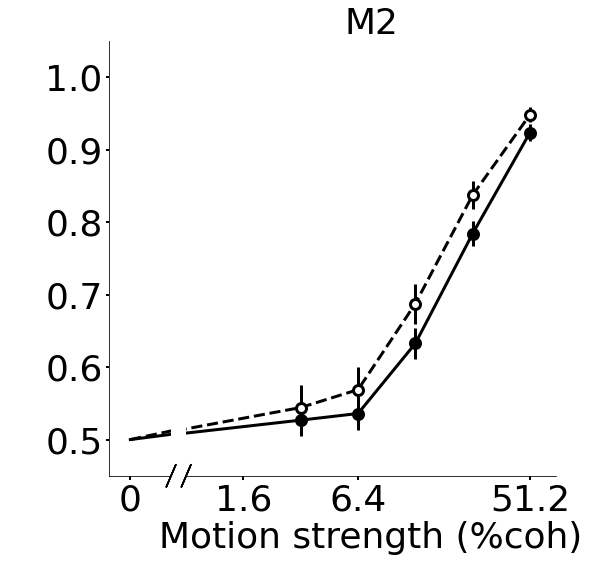

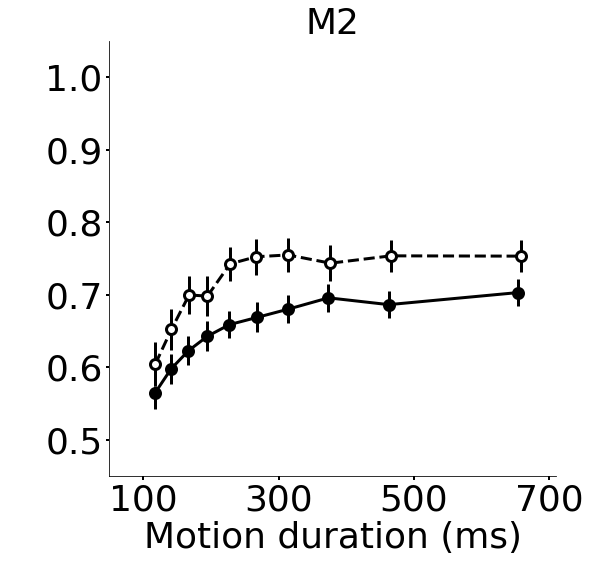

<Figure size 432x288 with 0 Axes>

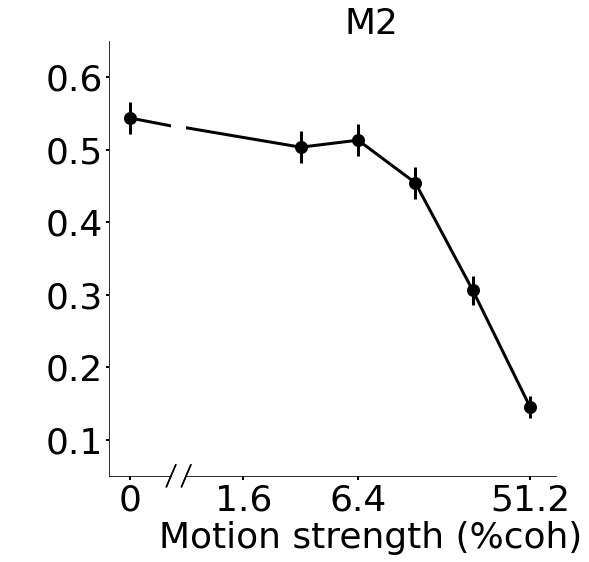

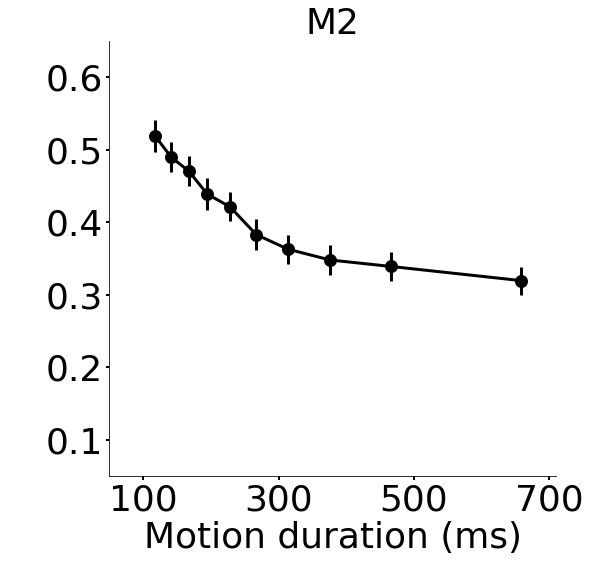

In [15]:
#figure 1b
acc_real_pos  = copy.copy(acc_real)
acc_reject_real_pos  = copy.copy(acc_reject_real)
for point in acc_real_pos[0]:
    point.performance = .5
for point in acc_reject_real_pos[0]:
    point.performance = .5
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(acc_reject_real_pos,ax, ax2,  _fmt = '--', _color = 'black', error = False)
acc_reject_real_pos.pop(0)
analysisCoherence(acc_reject_real_pos,ax, ax2,  _fmt = 'o', _color = 'white', error = True, _edge_color = 'black')
analysisCoherence(acc_reject_real_pos,ax, ax2,  _fmt = "none", _color = 'black', error = True)


analysisCoherence(acc_real_pos,ax,ax2,  _fmt = '-', _color = 'black', error = False)
acc_real_pos.pop(0)
analysisCoherence(acc_real_pos,ax, ax2,  _fmt = 'o', _color = 'black')
ax.set_ylabel("Accuracy", color = y_color)
ax.set_ylim([.45,1.05])

ax.set_yticks([.5, .6, .7, .8, .9, 1.])
#plt.tight_layout()
plt.title("M" + str(monkey), fontsize = 36)
plt.savefig('paper_figures/acc_reject_real_coh' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches='tight')

plt.figure()
analysisTime(acc_real, _fmt = 'o', _color = 'black', error = True)
analysisTime(acc_real, _fmt = '-', _color = 'black', error = False)
analysisTime(acc_reject_real, _fmt = '--', _color = 'black', error = False)
analysisTime(acc_reject_real, _fmt = 'o', _color = 'white', error= True, _edge_color='black')
analysisTime(acc_reject_real, _fmt = ' ', _color = 'black', error = True)
plt.ylabel("Accuracy", color = 'white')
plt.ylim([.45,1.05])
plt.yticks([.5, .6, .7, .8, .9, 1.])

#plt.tight_layout()
#custom_lines = [matplotlib.lines.Line2D([0], [0], color='red', lw=3),
#                matplotlib.lines.Line2D([0], [0], color='black', lw=3)]
#plt.legend(custom_lines, ['Sure bet rejected', 'Sure bet not shown'])
plt.savefig('paper_figures/acc_reject_real_time' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches='tight')

#fig 1c
plt.figure()
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(wage_real,ax,ax2, _fmt = 'o', _color = 'black')
analysisCoherence(wage_real,ax,ax2, _fmt = '-', _color = 'black', error = False)
plt.ylim([0.05, 0.65])
ax.set_yticks([.1, .2, .3, .4, .5, .6])
ax.set_ylabel("Probability sure", color = y_color)
#plt.tight_layout()
plt.title("M" + str(monkey), fontsize = 36)
plt.savefig('paper_figures/wage_real_coh' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches='tight')

plt.figure()
analysisTime(wage_real, _fmt = '-', _color = 'black', error = False)
analysisTime(wage_real, _fmt = 'o', _color = 'black', error = True)
plt.ylim([0.05, 0.65])
plt.yticks([.1, .2, .3, .4, .5, .6])
plt.ylabel("Probability sure", color = 'white')
#plt.tight_layout()
plt.savefig('paper_figures/wage_real_time' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches='tight')
plt.show()

# Distribuation of senosry evidence (Figure 2a, b)

AttributeError: module 'matplotlib.mlab' has no attribute 'normpdf'

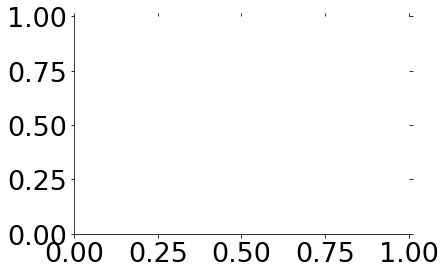

In [28]:
# figure 2a
matplotlib.rc('font', **font2)
axes = plt.gca()
figure = plt.gcf()
plt.axvline(0, color = 'black')
x = np.linspace(-4, 4, 300)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.tick_params(top = u'off', right = u'off')
for i in range(len(cohs)):
    c = cohs[i]
    for j in [1, -1]:
        mu =  j * c * k / 1000.0
        y = matplotlib.mlab.normpdf(x, mu, std_z)
        plt.plot(x, y, linewidth = 3, color = "black", alpha = .18 + 1.6 * c/1000)# colors[len(cohs)-(i+1)])
figure.set_size_inches(8,8)
axes.yaxis.set_visible(False)
plt.xlim([-4.2, 4.2])

axes.tick_params(direction='out', width = '2')

for label in axes.get_xticklabels()[::]:
    label.set_visible(False)

figure.set_size_inches(8,8)
plt.xlabel('Momentary observation')
#plt.tight_layout()
plt.ylim([0,.45])

plt.savefig('paper_figures/bayes_coh.png', format='png', dpi=100, bbox_inches='tight')

#figure 2b
plt.figure()
s = np.zeros(len(trials))
i = 0
for trial in trials:
    t = trial.getDuration() / float(step_time)
    sigma = std_z/ float(t ** .5)
    c = trial.getCoherence()
    mu = k * c / 1000.0
    if trial.getCorrectTarget() > 1: #left
        mu = -mu
    sigma_s = 3.59/ float(t ** .5)
    s[i] = np.random.normal(np.random.normal(mu, sigma), sigma_s)
    s[i] = np.random.normal(mu, sigma)
    s = np.array(s)
    i +=1
n, bins, patches = plt.hist(s, bins = 100, normed = True, alpha = .5, linewidth=1, color = 'blue', edgecolor = 'black')
# add a 'best fit' line
y = matplotlib.mlab.normpdf(bins, 0, np.std(s))
plt.plot(bins, y, 'r-', linewidth=4)
axes = plt.gca()
figure = plt.gcf()
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.tick_params(top = u'off', right = u'off')
for label in axes.get_xticklabels()[::]:
    label.set_visible(False)
axes.tick_params(direction='out', width = '2')
for label in axes.get_yticklabels()[1::2]:
    label.set_visible(False)
axes.yaxis.set_visible(False)
axes.tick_params(direction='out', width = '2')
figure.set_size_inches(8,8)

#plt.title (r'$b_0 = \mathcal{N}(0, \sigma_0^2)$')
plt.xlabel('Inferred coherence')
#plt.tight_layout()
plt.savefig('paper_figures/observations'  + str(monkey) + '.png', format='png', dpi=100, bbox_inches='tight')
plt.show()



AttributeError: module 'matplotlib.mlab' has no attribute 'normpdf'

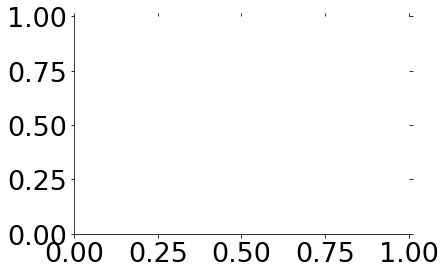

In [29]:
matplotlib.rc('font', **font2)
axes = plt.gca()
figure = plt.gcf()
plt.axvline(0, color = 'black')
x = np.linspace(-8, 8, 300)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.tick_params(top = u'off', right = u'off', bottom = u'off')
c = 2500
signal_alphas = [.7, .4]
for j in [1, -1]:
    mu =  j * c * k / 1000.0
    y = matplotlib.mlab.normpdf(x, mu, std_z*2)
    plt.plot(x, y, linewidth = 3, color = "black", alpha = signal_alphas[int((1-j)/2)])
plt.ylim([0,.3])
figure.set_size_inches(8,8)
axes.yaxis.set_visible(False)
plt.xlim([-8.2, 8.2])
plt.axvline(-mu*.7, color= 'black', linewidth = 3, ls = "--")
plt.axvline(mu*.7, color= 'black', linewidth = 3, ls = "--")

axes.tick_params(direction='out', width = '2')
    
plt.annotate(r'$c_2$', xy = (-mu - .6, .25), xytext = (-1 * mu, .2),
        textcoords = 'offset points', ha = 'left', va = 'bottom')

plt.annotate(r'$c_1$', xy = (0.1, .25), xytext = (0, .2),
        textcoords = 'offset points', ha = 'left', va = 'bottom')


plt.annotate(r'$c_2$', xy = (mu - .4, .25), xytext = (mu, .2),
        textcoords = 'offset points', ha = 'left', va = 'bottom')


for label in axes.get_xticklabels()[::]:
    label.set_visible(False)

plt.xlabel("Choices", color = "white")
figure.set_size_inches(8,8)
#plt.tight_layout()

plt.savefig('paper_figures/SDT.png', format='png', dpi=100, bbox_inches='tight')


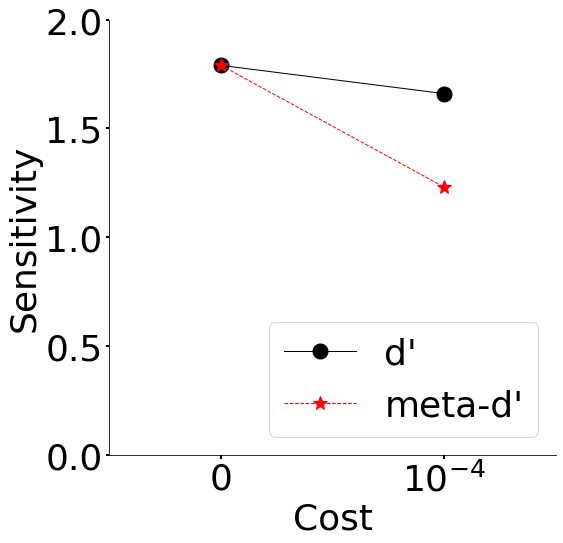

In [18]:
setPlot()
plt.plot([0, 10**-4], [1.79, 1.66], "-o", color = "black", linewidth = 1, markersize = 15)
plt.plot([0, 10**-4], [1.79, 1.23], "--*", color = "red", linewidth = 1, markersize = 15 )
plt.xlim([5 * -10**-5, 1.5 * 10**-4])
plt.xticks([0, 10**-4], ['0', r'$10^{-4}$'])
plt.xlabel('Cost')
plt.ylabel('Sensitivity')
plt.ylim([0,2])
plt.legend (["d'", "meta-d'"], loc = 4)
plt.title("")
plt.savefig('paper_figures/d-cost.png', format='png', dpi=600, bbox_inches='tight')


<ipython-input-19-f2eb13430eb6>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axes1 = plt.gcf().add_subplot(111)


TypeError: ticklabel_format() got an unexpected keyword argument 'color'

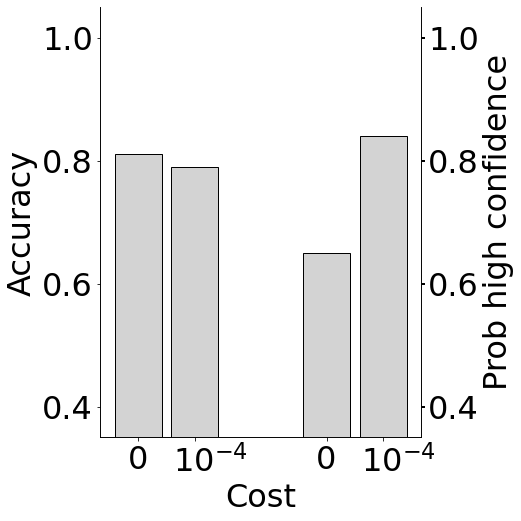

In [19]:
matplotlib.rc('font', **font3)
plt.ylim([.35,1.05])
axes1 = plt.gcf().add_subplot(111)
axes2 = axes1.twinx()
axes2.set_ylim([0.35, 1.05])
axes2.tick_params(top = u'off')
axes2.tick_params(direction='out', width = '2')
axes2.spines['top'].set_visible(False)
axes1.spines['top'].set_visible(False)
axes1.set_ylabel("Accuracy")
axes2.set_ylabel("Prob high confidence")
axes1.set_xlabel("Cost")
axes1.set_xticks([1, 1.3, 2, 2.3])
axes1.set_xticklabels(2 * ['0', r'$\quad 10^{-4}$'])

index = 1.5 * np.array(range(3))+ 1
bar_width = 0.25
opacity = 0.8
plt.bar(1, .81, bar_width, color = 'lightgray', edgecolor = 'black' ) 
plt.bar(1.3, .79, bar_width, color = 'lightgray', edgecolor = 'black') 

plt.bar(2, .65, bar_width, color = 'lightgray', edgecolor = 'black') 
plt.bar(2.3, .84, bar_width, color = 'lightgray', edgecolor = 'black') 

plt.gcf().set_size_inches(8,8)

plt.tight_layout()
axes2.tick_params(direction='out', width = '2')
axes2.ticklabel_format(color = "white")
plt.savefig('paper_figures/post-cost.png' , format='png', dpi=100, bbox_inches= 'tight')
plt.show()

In [ ]:
plt.ylim([.25,.95])
axes1 = plt.gcf().add_subplot(111)
axes2 = axes1.twinx()
axes2.set_ylim([0.25, .95])
axes2.tick_params(top = u'off')
axes2.tick_params(direction='out', width = '2')
axes2.spines['top'].set_visible(False)
axes1.spines['top'].set_visible(False)
axes1.set_ylabel("P(high conf|correct)")
axes2.set_ylabel("P(high conf|incorrect)")
axes1.set_xlabel("Cost")
axes1.set_xticks([1, 1.3, 2, 2.3])
axes1.set_xticklabels(2 * ['0', r'$\quad 10^{-4}$'])

index = 1.5 * np.array(range(3))+ 1
bar_width = 0.25
opacity = 0.8
plt.bar(1, .723, bar_width, color = 'lightgray', edgecolor = 'black' ) 
plt.bar(1.3, .869, bar_width, color = 'lightgray', edgecolor = 'black') 

plt.bar(2, .314, bar_width, color = 'lightgray', edgecolor = 'black') 
plt.bar(2.3, .700, bar_width, color = 'lightgray', edgecolor = 'black') 
#plt.bar(2.3, .610, bar_width, color = 'lightgray', edgecolor = 'black', hatch = "/") 


plt.gcf().set_size_inches(8,8)

plt.tight_layout()
axes2.tick_params(direction='out', width = '2')
axes2.ticklabel_format(color = "white")
plt.savefig('paper_figures/cor-incor-cost.png' , format='png', dpi=100, bbox_inches= 'tight')
plt.show()


# Update model (figure 2 c)

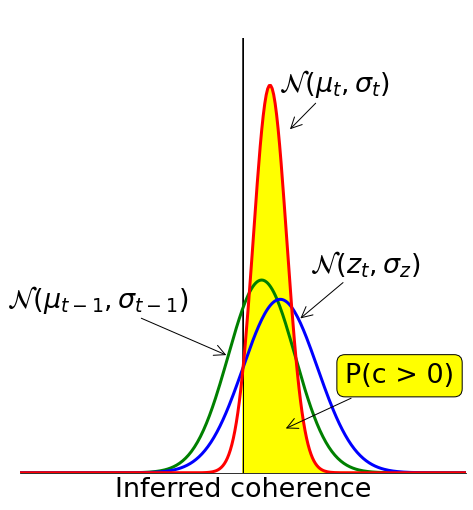

In [30]:
from scipy.stats import norm

matplotlib.rc('font', **font2)
axes = plt.gca()
fig = plt.gcf()
axes.set_xlim([-6,6])
axes.set_ylim([0,1.])
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['left'].set_visible(False)
plt.axvline(0, color = 'black')
x = np.linspace(-6, 6, 300)


mu_0 = 0.5
sigma_0 = .9

mu_o = 1
sigma_o = 1

mu_1 = (mu_o * sigma_0 * sigma_0 + mu_0 * sigma_o * sigma_o) / float(sigma_o **2 + sigma_0 **2)
sigma_1 = (sigma_o * sigma_0 * sigma_o * sigma_0) / float(sigma_o **2 + sigma_0**2)

EPSILON = 0.001
x_inside = []
y_inside = []
y = np.linspace(0,6,300)
for x_in in y:
        y_in = EPSILON 
        x_inside += [x_in]
        y_inside += [y_in]
        y_in = max(0, norm.pdf(x_in, mu_1, sigma_1) - EPSILON)
        x_inside += [x_in]
        y_inside += [y_in]
plt.plot(x_inside, y_inside, 'yellow')
plt.plot([0,6], [0,0] , linewidth = 1, color = 'black')
plt.plot([0,0], [0,6], linewidth = 1, color = 'black')

plt.plot(x,norm.pdf(x, mu_0, sigma_0), linewidth = 3, color = 'green')
plt.annotate(r'$\mathcal{N}(\mu_{t-1}, \sigma_{t-1})$', xy = (mu_0 - sigma_0, norm.pdf(mu_0 - sigma_0, mu_0,sigma_0)), xytext = (mu_0-40, norm.pdf(mu_0,sigma_0) + .07 + 40),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        #bbox = dict(boxstyle = 'round,pad=1', fc = 'white', alpha = 1),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))



plt.plot(x,norm.pdf(x, mu_o, sigma_o), linewidth = 3, color = 'blue')
plt.annotate(r'$\mathcal{N}(z_{t}, \sigma_z)$', xy = (mu_o + .5*sigma_o, norm.pdf(mu_o + .5*sigma_o, mu_o,sigma_o)), xytext = (mu_o+10, norm.pdf(mu_o,sigma_o) + 40),
        textcoords = 'offset points', ha = 'left', va = 'bottom',
        #bbox = dict(boxstyle = 'round,pad=1', fc = 'white', alpha = 1),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))



plt.plot(x,norm.pdf(x, mu_1, sigma_1), linewidth = 3, color = 'red')
plt.annotate(r'$\mathcal{N}(\mu_{t}, \sigma_{t})$', xy = (mu_1 + .5*sigma_o, norm.pdf(mu_1 + .5*sigma_1, mu_1,sigma_1)), xytext = (mu_1 - 10, norm.pdf(mu_1,sigma_1) + .5 + 30),
        textcoords = 'offset points', ha = 'left', va = 'bottom',
        #bbox = dict(boxstyle = 'round,pad=1', fc = 'white', alpha = 1),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.annotate(r'P(c > 0)', xy = (mu_o + .1, .1), xytext = (mu_o + 60, .55 + 40),
        textcoords = 'offset points', ha = 'left', va = 'bottom',
        bbox = dict(boxstyle = 'round, pad= .3', fc = 'yellow', alpha = 1),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))



axes.get_xaxis().set_ticks([])
#plt.title("")
plt.xlabel('Inferred coherence')
fig.set_size_inches(8,8)
plt.title (r'  ')
axes.yaxis.set_visible(False)
plt.savefig('paper_figures/update.png', format='png', dpi=100, bbox_inches='tight')
plt.show()

# Continuous (Gaussian Prior) POMDP (Figure 3)

In [21]:
matplotlib.rc('font', **font)
ap = ContinuousPOMDP(k, 0, std_i, std_z_s, step_time, num_samples) #adjusted 
env = Environment(ap, k, std_z, step_time, num_samples)  #because the sigma of adjusted is different
acc_results = analysis.generateForMultipleCohs(env, trials_acc, cohs, 'Accuracy')
confidence_results = analysis.generateForMultipleCohs(env, trials_acc, cohs, 'Confidence')
wage_results = analysis.generateForMultipleCohs(env, trials_sure, cohs, 'Wage', threshold_s)
reject_results = analysis.generateForMultipleCohs(env, trials_sure, cohs, 'Reject', threshold_s)

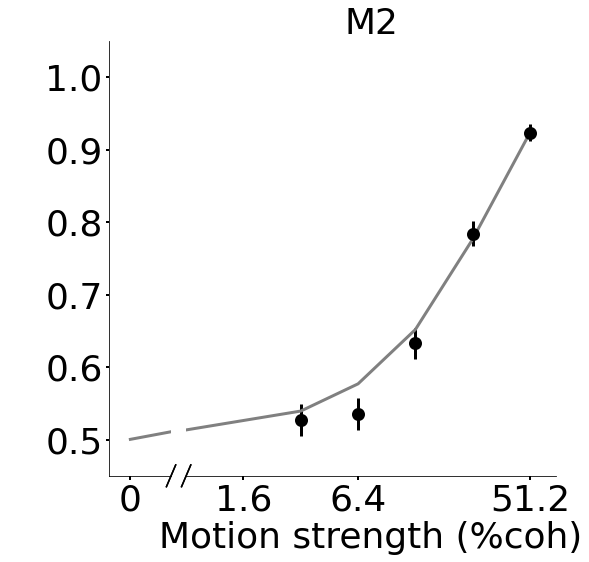

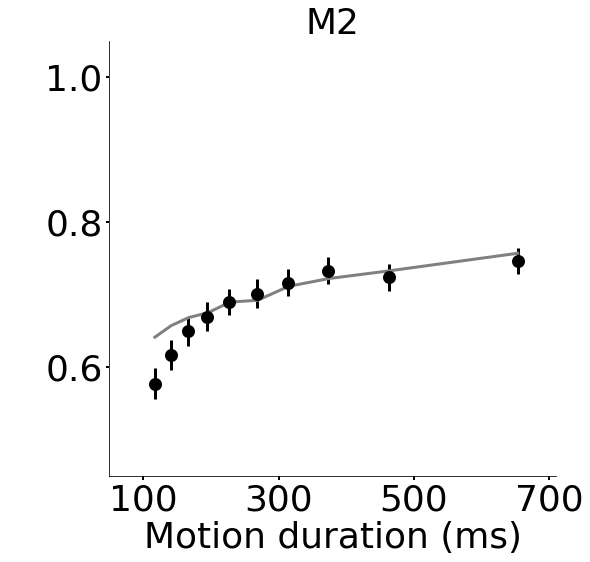

<Figure size 432x288 with 0 Axes>

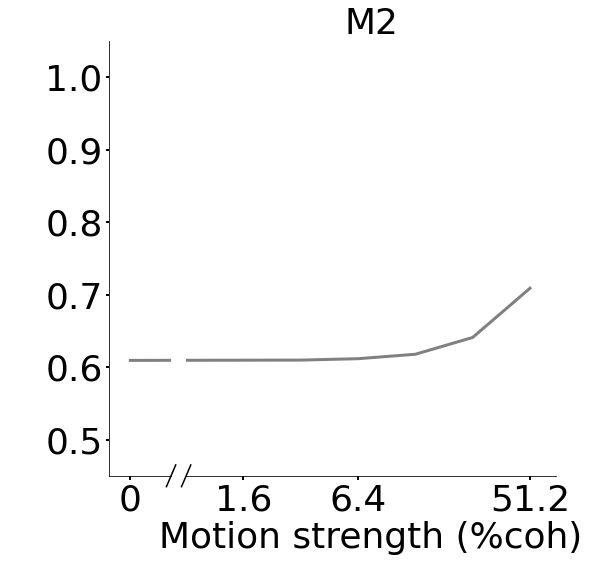

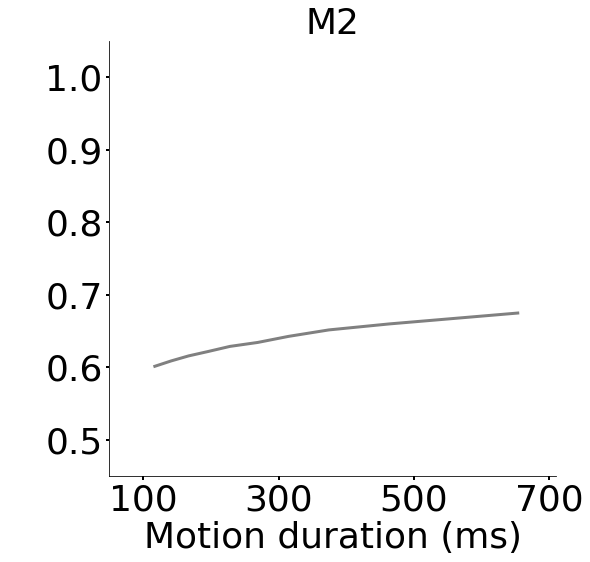

<Figure size 432x288 with 0 Axes>

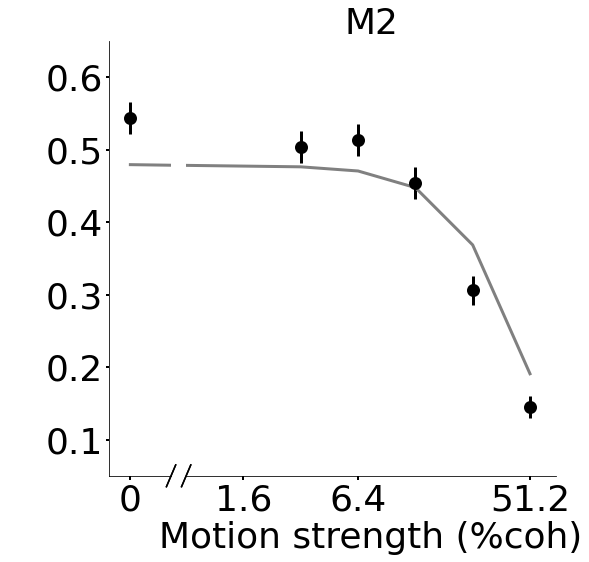

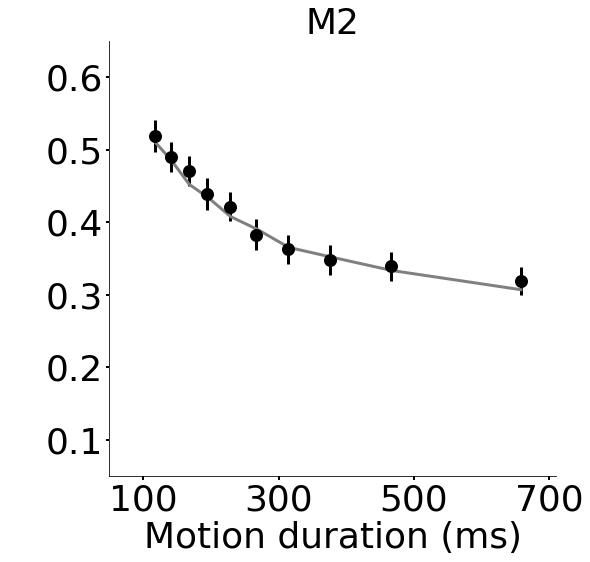

<Figure size 432x288 with 0 Axes>

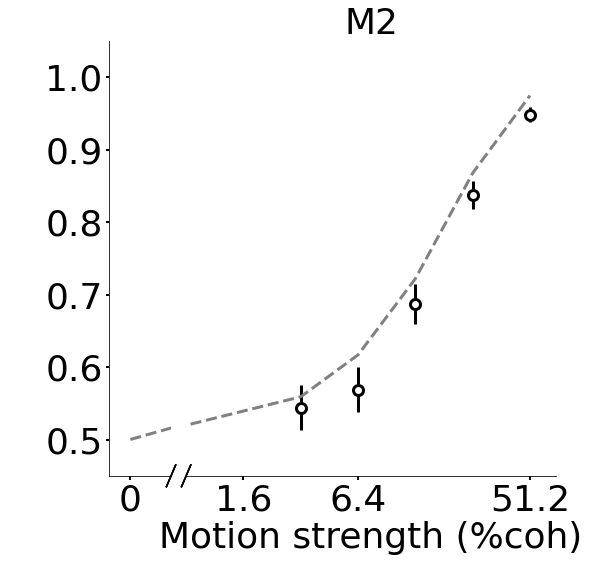

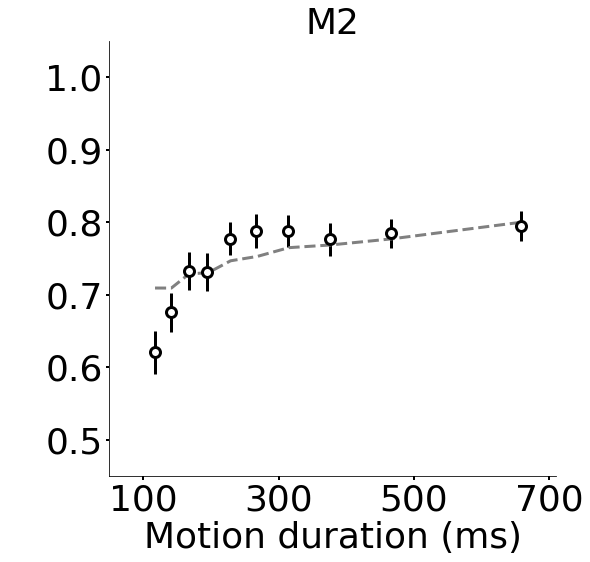

In [22]:
#figure 3a 
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(acc_results, ax, ax2, _fmt = '-', error = False)
analysisCoherence(acc_real_pos,ax, ax2, _fmt = 'o', _color = 'black')
ax.set_ylabel("Accuracy", color = y_color)
plt.title("M" + str(monkey), fontsize = 36)
ax.set_ylim([.45,1.05])
ax.set_yticks([.5, .6, .7, .8, .9, 1.])
plt.savefig('paper_figures/acc_coh' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')

plt.figure()
acc_results_pos = copy.copy(acc_results)
acc_results_pos.pop(0)
analysisTime(acc_real_pos, _fmt = 'o', _color = "black", error = True)
analysisTime(acc_results_pos, _fmt = '-', error = False)
plt.ylabel("Accuracy", color = "white")
plt.ylim([.45,1.05])
ax.set_yticks([.5, .6, .7, .8, .9, 1.])
plt.savefig('paper_figures/acc_time' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')

#figure 3b 
plt.figure()
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(confidence_results, ax,ax2, _fmt = '-', error = False)
#analysisCoherence(confidence_results,ax, ax2, _fmt = 'o')
plt.title("M" + str(monkey), fontsize = 36)
ax.set_ylabel("Predicted confidence", color = y_color)
ax.set_ylim([.45, 1.05])
ax.set_yticks([.5, .6, .7, .8, .9, 1.])
plt.savefig('paper_figures/confidence_coh' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')

plt.figure()
analysisTime(confidence_results, _fmt = '-', _color = 'gray', error = False)
#analysisTime(confidence_results, _fmt = 'o', _color = 'blue', error = True)
plt.ylabel("Predicted confidence", color = "white")
plt.ylim([0.45, 1.05])
plt.yticks([.5, .6, .7, .8, .9, 1.])
plt.savefig('paper_figures/confidence_time' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')

#fig 3c
plt.figure()
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(wage_real, ax, ax2, _fmt = 'o', _color = 'black')
analysisCoherence(wage_results, ax, ax2, _fmt = '-', _color = 'gray', error = False)
plt.title("M" + str(monkey), fontsize = 36)
ax.set_ylim([0.05, 0.65])
ax.set_yticks([.1, .2, .3, .4, .5, .6])
ax.set_ylabel("Probability sure", color = y_color)
plt.savefig('paper_figures/wage_coh' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')

plt.figure()
analysisTime(wage_results, _fmt = '-', _color = 'gray', error = False)
analysisTime(wage_real, _fmt = 'o', _color = 'black', error = True)
plt.ylim([0.05, 0.65])
plt.yticks([.1, .2, .3, .4, .5, .6])
plt.ylabel("Probability sure", color = "white")
plt.savefig('paper_figures/wage_time' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')

#figure 3d
plt.figure()
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(reject_results, ax, ax2,  _fmt = '--', error = False)
analysisCoherence(acc_reject_real_pos, ax,ax2, _fmt = 'o', _color = "white", error= True, _edge_color="black")
analysisCoherence(acc_reject_real_pos,ax, ax2, _fmt = ' ', _color = "black", error= True, _edge_color="white")
ax.set_ylabel("Accuracy", color = y_color)
plt.title("M" + str(monkey), fontsize = 36)
ax.set_ylim([.45,1.05])
ax.set_yticks([.5, .6, .7, .8, .9, 1.])
plt.savefig('paper_figures/acc_reject_coh' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches='tight')

plt.figure()
reject_results.pop(0)
analysisTime(reject_results, _fmt = '--', error = False)
analysisTime(acc_reject_real_pos, _fmt = 'o', _color = "white", error= True, _edge_color="black")
analysisTime(acc_reject_real_pos, _fmt = ' ', _color = "black", error= True, _edge_color="white")
plt.ylabel("Accuracy", color = "white")
plt.ylim([.45,1.05])
plt.yticks([.5, .6, .7, .8, .9, 1.])

plt.savefig('paper_figures/acc_reject_time' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches='tight')

plt.show()

# Hard Easy Effect (figure 7a)

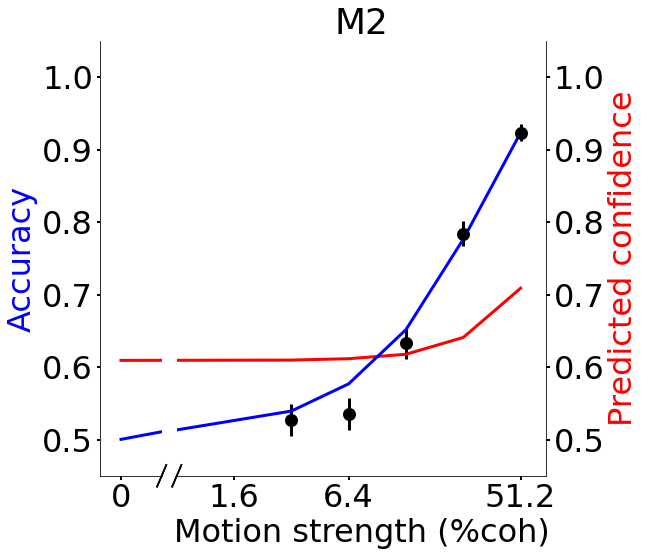

In [23]:
matplotlib.rc('font', **font3)
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(confidence_results,ax, ax2, _color = 'red', _fmt = '-', error = False)
#analysisCoherence(confidence_results, ax, ax2,  _fmt = 'o')
analysisCoherence(acc_real_pos,ax, ax2, _color = 'black', _fmt = 'o')
analysisCoherence(acc_results, ax, ax2, _color = 'blue', _fmt = '-', error = False)

ax2.spines['right'].set_visible(True)
ax2.tick_params(labelright='on')  
ax2.tick_params(right = u'on')

#plt.ylabel("Predicted confidence", color = 'blue')
#plt.ylim([.35,1.05])
#axes1 = plt.gcf().add_subplot(111)
#axes2 = axes1.twinx()
#axes2.set_ylim([0.35, 1.05])
#axes2.tick_params(top = u'off')
#axes2.tick_params(direction='out', width = '2')
#axes2.spines['top'].set_visible(False)
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Predicted confidence', color = 'red')
ax.set_ylabel("Accuracy", color = 'blue')
ax.set_ylim([.45, 1.05])
ax.set_yticks([.5, .6, .7, .8, .9, 1.])

plt.gcf().set_size_inches(8,8)

#for label in axes2.get_yticklabels():
#    label.set_visible(False)
#plt.tight_layout()
#axes2.tick_params(direction='out', width = '2')
plt.title("M" + str(monkey), fontsize = 36)
plt.savefig('paper_figures/hard_easy'+ str(monkey) + '.png' , format='png', dpi=100, bbox_inches= 'tight')
plt.show()

# Volaitlity

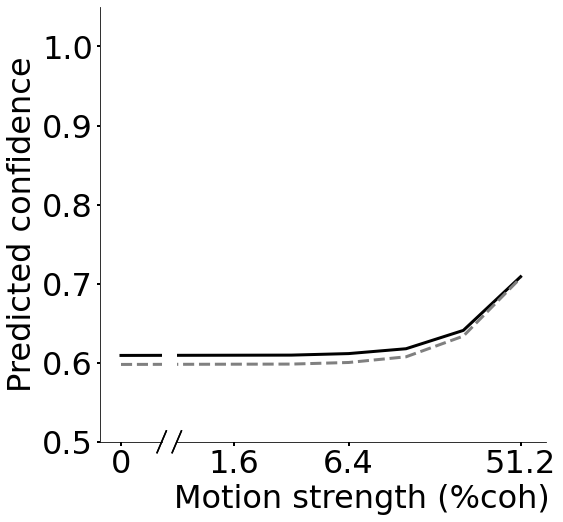

<Figure size 432x288 with 0 Axes>

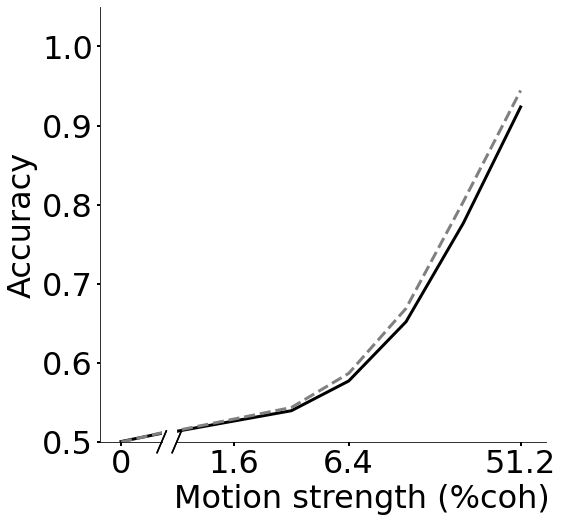

<Figure size 432x288 with 0 Axes>

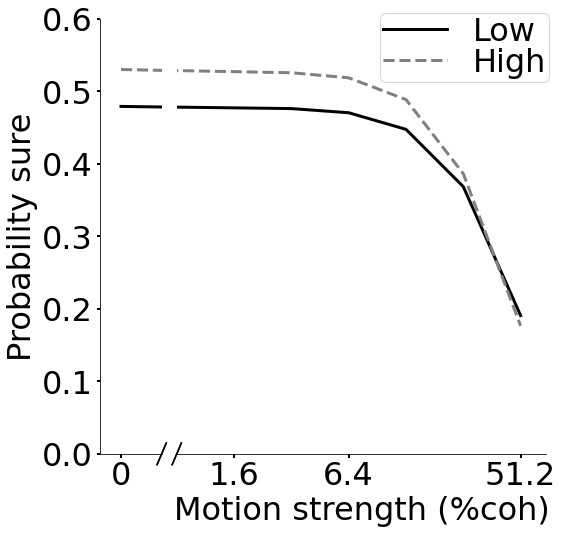

In [24]:
h_std_z = 1.5
envh = Environment(ap, k, h_std_z, step_time, num_samples)
accuracy_results_h = analysis.generateForMultipleCohs(envh, trials_acc, cohs, 'Accuracy')
confidence_results_h = analysis.generateForMultipleCohs(envh, trials_acc, cohs, 'Confidence')   
wage_results_h = analysis.generateForMultipleCohs(envh, trials_sure, cohs, 'Wage', threshold_s)

acc_pos  = copy.copy(acc_results)
acc_h_pos  = copy.copy(accuracy_results_h)
acc_pos.pop(0)
acc_h_pos.pop(0)
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(confidence_results, ax, ax2, _color = 'black', _fmt = '-', error = False)
#analysisCoherence(confidence_results, ax, ax2, _fmt = 'o')
analysisCoherence(confidence_results_h, ax, ax2, _color = 'gray', _fmt = '--', error = False)
#analysisCoherence(confidence_results_h, ax, ax2, _color = 'red', _fmt = 'o')
ax.set_ylabel("Predicted confidence")
custom_lines = [matplotlib.lines.Line2D([0], [0], color='black', lw=3),
                matplotlib.lines.Line2D([0], [0], color='gray', lw=3, ls = "--")]
#plt.legend(custom_lines, ['Low volatility', 'High volatility'],loc = 0, fontsize = 32, labelspacing= 0,  borderpad = 0.1)

ax.set_ylim([.5,1.05])
plt.savefig('paper_figures/confidence_low_high.png' , format='png', dpi=100, bbox_inches = "tight")

plt.figure()
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(acc_results, ax,ax2, _color = 'black', _fmt = '-', error = False)
#analysisCoherence(acc_pos, ax, ax2, _fmt = 'o')
analysisCoherence(accuracy_results_h, ax, ax2,  _color = 'gray', _fmt = '--', error = False)
#analysisCoherence(acc_h_pos, ax, ax2, _color = 'red', _fmt = 'o')
ax.set_ylabel("Accuracy")

ax.set_ylim([.5,1.05])
plt.savefig('paper_figures/acc_low_high.png' , format='png', dpi=100, bbox_inches = "tight")

plt.figure()
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(wage_results, ax, ax2, _fmt = '-', _color = 'black', error = False)
analysisCoherence(wage_results_h, ax, ax2, _fmt = '--', _color = 'gray', error = False)
ax.set_ylabel("Probability sure")

custom_lines = [matplotlib.lines.Line2D([0], [0], color='black', lw=3),
                matplotlib.lines.Line2D([0], [0], color='gray', lw=3, ls = "--")]
plt.legend(custom_lines, ['Low', 'High'],loc = 1, fontsize = 32, labelspacing= 0,  borderpad = 0.1, bbox_to_anchor=(1.05, 1.05))

ax.set_ylim([0,.6])
plt.savefig('paper_figures/wage_low_high.png' , format='png', dpi=100, bbox_inches = "tight")


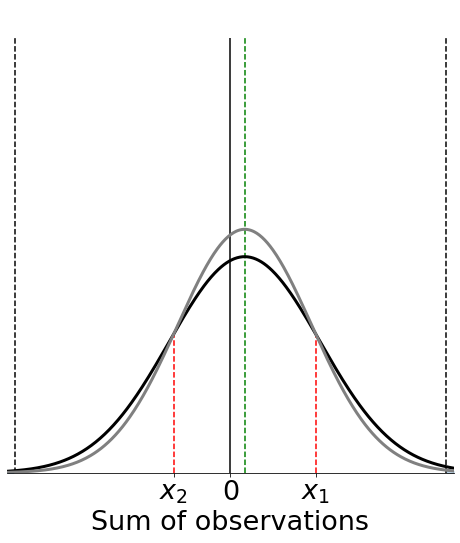

In [25]:
from scipy.stats import norm

matplotlib.rc('font', **font2)
axes = plt.gca()
fig = plt.gcf()
axes.set_xlim([-25,25])
axes.set_ylim([0,.095])
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['left'].set_visible(False)
plt.axvline(0, color = 'black')
x = np.linspace(-25, 25, 500)

c = .064
t = 25

mu = c * t
sigma_l = std_z * (t**.5)

sigma_h = h_std_z * (t**.5)
th = norm.ppf(.85) * (t * std_z_s**2 + (std_z_s**4)* (std_i ** -2) )**.5
plt.plot(x,norm.pdf(x, mu, sigma_l), linewidth = 3, color = 'black')
plt.plot(x,norm.pdf(x, mu, sigma_h), linewidth = 3, color = 'gray')
dif = norm.pdf(x, mu, sigma_l) - norm.pdf(x, mu, sigma_h)
x1_in = np.argmin(np.abs(dif[50:-50]))
x1_x = x[x1_in + 50]
dif[x1_in + 50] +=100
x2_in = np.argmin(np.abs(dif[50:-50]))
x2_x = x[x2_in + 50]
plt.vlines(th, 0, 100, linestyle = "dashed", color = "black")
plt.vlines(-th, 0, 100, linestyle = "dashed", color = "black")
plt.vlines(mu, 0, 100, linestyle = "dashed", color = "green")
plt.vlines(x1_x, 0, norm.pdf([x1_x], mu, sigma_l), linestyle = "dashed", color = "red")
plt.vlines(x2_x, 0, norm.pdf([x1_x], mu, sigma_l), linestyle = "dashed", color = "red")
plt.fill_between(x[int(10*(th+25)):], norm.pdf(x[int(10*(th+25)):], mu, sigma_h), 0, color = "C0", alpha=0.25)
plt.fill_between(x[:int(10*(-th+25))], norm.pdf(x[:int(10*(-th+25))], mu, sigma_h), 0, color = "C0", alpha=0.25)

plt.xticks([x2_x, 0, x1_x], [r'$x_1$', '0', r'$x_2$'])
#plt.title("")
plt.xlabel('Sum of observations')
fig.set_size_inches(8,8)
plt.title (r'  ')
axes.yaxis.set_visible(False)
plt.savefig('paper_figures/volat_sch.png', format='png', dpi=100, bbox_inches='tight')
plt.show()

# Cost(figure 4a, 4b, 4c)

In [26]:
cost_low = 10 ** -4
cost_high = 7.5 * 10 ** -3

In [27]:
num_samples = 20000
cpc = POMDPWithCostSz(k, 0, std_z, std_i, cohs, cost_low, 1000, std_z_s, 10.0, num_samples)
envc = Environment(cpc, k, std_z, step_time, num_samples)  #because the sigma of adjusted is different

FileNotFoundError: [Errno 2] No such file or directory: 'observations/fixed_0.0_0.1_3.59_0.87_1.69_20000.npy'

In [ ]:
wage_results_c = analysis.generateForMultipleCohs(cpc, trials_sure, cohs, 'Wage', threshold_s)
confidence_results_c = analysis.generateForMultipleCohs(cpc, trials_acc, cohs, 'Confidence')
acc_results_c = analysis.generateForMultipleCohs(cpc, trials_acc, cohs, 'Accuracy')

In [ ]:
cpch = POMDPWithCostSz(k, 0, std_z, std_i, cohs, cost_high, 1000, std_z_s, 10.0, num_samples)
envch = Environment(cpch, k, std_z, step_time, num_samples)  #because the sigma of adjusted is different

In [ ]:
wage_results_ch = analysis.generateForMultipleCohs(cpch, trials_sure, cohs, 'Wage', threshold_s)
confidence_results_ch = analysis.generateForMultipleCohs(cpch, trials_acc, cohs, 'Confidence')
acc_results_ch = analysis.generateForMultipleCohs(cpch, trials_acc, cohs, 'Accuracy')
acc_pos  = copy.copy(acc_results)
acc_c_pos  = copy.copy(acc_results_c)
acc_pos.pop(0)
acc_c_pos.pop(0)
acc_ch_pos  = copy.copy(acc_results_ch)
acc_ch_pos.pop(0)

In [ ]:
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(acc_results, ax,ax2, _fmt = '-', error = False)
analysisCoherence(acc_results_c, ax, ax2,  _color = 'green', _fmt = '-', error = False)
analysisCoherence(acc_results_ch, ax, ax2,  _color = 'red', _fmt = '-', error = False)


custom_lines = [matplotlib.lines.Line2D([0], [0], color='blue', lw=3),
                matplotlib.lines.Line2D([0], [0], color='green', lw=3),  
                matplotlib.lines.Line2D([0], [0], color='red', lw=3)
               ]

if monkey == 1: 
    plt.legend(custom_lines, ['Zero', 'Low', 'High'], loc = 2, fontsize = 36, 
               labelspacing= 0, bbox_to_anchor=(-.2, 1))

ax.set_ylabel("Accuracy")
#plt.title("M" + str(monkey), fontsize = 36)
ax.set_ylim([.45,1.05])
plt.yticks([.5, .6, .7, .8, .9, 1.])
plt.savefig('paper_figures/acc_cost_coh' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = "tight")

plt.figure()
analysisTime(acc_results_pos, _fmt = '-', _color = 'blue', error = False)
analysisTime(acc_c_pos, _color = 'green', _fmt = '-', error = False)
analysisTime(acc_ch_pos, _color = 'red', _fmt = '-', error = False)
plt.ylabel("Predicted confidence", color = "white")
plt.ylim([0.45, 1.05])
plt.title("")
plt.yticks([.5, .6, .7, .8, .9, 1.])
plt.savefig('paper_figures/acc_cost_time' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')


plt.figure()
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(confidence_results, ax, ax2, _fmt = '-', error = False)
analysisCoherence(confidence_results_c, ax, ax2,  _color = 'green', _fmt = '-', error = False)
analysisCoherence(confidence_results_ch, ax, ax2,  _color = 'red', _fmt = '-', error = False)
#plt.title("M" + str(monkey), fontsize = 36)
ax.set_ylabel("Predicted confidence", color = y_color)
ax.set_ylim([.45, 1.05])
ax.set_yticks([.5, .6, .7, .8, .9, 1.])
plt.savefig('paper_figures/confidence_cost_coh' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')


plt.figure()
analysisTime(confidence_results, _fmt = '-', _color = 'blue', error = False)
analysisTime(confidence_results_c, _color = 'green', _fmt = '-', error = False)
analysisTime(confidence_results_ch, _color = 'red', _fmt = '-', error = False)
plt.ylabel("Predicted confidence", color = "white")
plt.ylim([0.45, 1.05])
plt.yticks([.5, .6, .7, .8, .9, 1.])
plt.title("")
plt.savefig('paper_figures/confidence_cost_time' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')

#fig 4c
plt.figure()
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(wage_results, ax, ax2, _fmt = '-', _color = 'blue', error = False)
analysisCoherence(wage_results_c, ax, ax2, _fmt = '-', _color = 'green', error = False)
analysisCoherence(wage_results_ch, ax, ax2, _fmt = '-', _color = 'red', error = False)
#plt.title("M" + str(monkey), fontsize = 36)
plt.ylim([0.02, .62])
plt.yticks([.1, .2, .3, .4, .5, .6])
ax.set_ylabel("Probability sure", color = y_color)
plt.savefig('paper_figures/wage_cost_coh' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')

plt.figure()
analysisTime(wage_results, _fmt = '-', _color = 'blue', error = False)
analysisTime(wage_results_c, _fmt = '-', _color = 'green', error = False)
analysisTime(wage_results_ch, _fmt = '-', _color = 'red', error = False)

plt.ylim([0.02, .62])
plt.yticks([.1, .2, .3, .4, .5, .6])
plt.ylabel("Probability sure", color = "white")
plt.title("")



plt.savefig('paper_figures/wage_cost_time' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')

plt.show()

In [ ]:
wage_results_c2 = analysis.generateForMultipleCohs(cpc, trials_sure, cohs, 'Wage', threshold_s +.01)
wage_results_ch2 = analysis.generateForMultipleCohs(cpch, trials_sure, cohs, 'Wage', threshold_s +.04 )

In [ ]:
plt.figure()
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(wage_results, ax, ax2, _fmt = '-', _color = 'blue', error = False)
analysisCoherence(wage_results_c2, ax, ax2, _fmt = '-', _color = 'green', error = False)
analysisCoherence(wage_results_ch2, ax, ax2, _fmt = '-', _color = 'red', error = False)
analysisCoherence(wage_real, ax, ax2, _fmt = 'o', _color = 'black', error = True)
plt.title("M" + str(monkey), fontsize = 36)
plt.ylim([0.02, .63])
plt.yticks([.1, .2, .3, .4, .5, .6])
ax.set_ylabel("Probability sure", color = y_color)
plt.savefig('paper_figures/wage_cost_adj_coh' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')

plt.figure()
analysisTime(wage_results, _fmt = '-', _color = 'blue', error = False)
analysisTime(wage_results_c2, _fmt = '-', _color = 'green', error = False)
analysisTime(wage_results_ch2, _fmt = '-', _color = 'red', error = False)
analysisTime(wage_real, _fmt = 'o', _color = 'black', error = True)

plt.ylim([0.02, .63])
plt.yticks([.1, .2, .3, .4, .5, .6])
plt.ylabel("Probability sure", color = "white")

custom_lines = [matplotlib.lines.Line2D([0], [0], color='blue', lw=3),
                matplotlib.lines.Line2D([0], [0], color='green', lw=3),  
                matplotlib.lines.Line2D([0], [0], color='red', lw=3)
               ]

if monkey == 2: 
    plt.legend(custom_lines, ['Zero', 'Low', 'High'], loc = 3, fontsize = 28, 
               labelspacing= 0, borderpad = 0.2)

plt.savefig('paper_figures/wage_cost_adj_time' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')

plt.show()

# Priors (figure 4)

In [ ]:
# model data
dp = DiscretePOMDP(k, cohs, std_z, step_time, num_samples) #discrete
kp = KnownCPOMDP(k, std_z, step_time, num_samples) #known coherence
ap = ContinuousPOMDP(k, mu_i, std_i2, std_z, step_time, num_samples) #not adjusted 
env = Environment(ap, k, std_z, step_time, num_samples)  #because the sigma of adjusted is different

acc_results_dp = analysis.generateForMultipleCohs(dp, trials_acc, cohs, 'Accuracy')
confidence_results_dp = analysis.generateForMultipleCohs(dp, trials_acc, cohs, 'Confidence')
#wage_results_dp = analysis.generateForMultipleCohs(dp, trials_sure, cohs, 'Wage', threshold_d)
#reject_results_dp = analysis.generateForMultipleCohs(dp, trials_sure, cohs, 'Reject', threshold_d)

confidence_results_kp = analysis.generateForMultipleCohs(kp, trials_acc, cohs, 'Confidence')
#wage_results_kp = analysis.generateForMultipleCohs(kp, trials_sure, cohs, 'Wage', threshold_accuracy)
#acc_results_kp = analysis.generateForMultipleCohs(kp, trials_acc, cohs, 'Accuracy')

acc_results_ap = analysis.generateForMultipleCohs(env, trials_acc, cohs, 'Accuracy')
confidence_results_ap = analysis.generateForMultipleCohs(env, trials_acc, cohs, 'Confidence')
#wage_results_ap = analysis.generateForMultipleCohs(env, trials_sure, cohs, 'Wage', threshold_s)
#reject_results_ap = analysis.generateForMultipleCohs(env, trials_sure, cohs, 'Reject', threshold_s)

In [ ]:
#figure 4a 
plt.figure()
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
#analysisCoherence(confidence_results, ax, ax2, _color = 'blue', _fmt = 'o')
analysisCoherence(confidence_results, ax, ax2, _color = 'red', _fmt = '-', error = False)
analysisCoherence(confidence_results_dp, ax, ax2,  _color = 'black', _fmt = '-', error = False)
#analysisCoherence(acc_real_pos, ax, ax2, _color = 'black', _fmt = 'o')
#analysisCoherence(confidence_results_kp, ax, ax2, _color = 'gray', _fmt = '-', error = False)
#analysisCoherence(confidence_results_kp, ax, ax2, _color = 'magenta', _fmt = 'o')
#analysisCoherence(confidence_results_ap, ax, ax2, _color = 'green', _fmt = '-', error = False)
#analysisCoherence(confidence_results_ap, ax, ax2, _color = 'green', _fmt = 'o')
ax.set_ylabel("Confidence", color = y_color)
plt.title("M" + str(monkey), fontsize = 36)
ax.set_ylim([.45, 1.05])
ax.set_yticks([.5, .6, .7, .8, .9, 1.])

custom_lines = [matplotlib.lines.Line2D([0], [0], color='red', lw=3),
                matplotlib.lines.Line2D([0], [0], color='black', lw=3),
                #matplotlib.lines.Line2D([0], [0], color='magenta', lw=3),
                #matplotlib.lines.Line2D([0], [0], color='green', lw=3),
                #matplotlib.lines.Line2D([0], [0], color='gray', lw=3)
               ]


    
plt.savefig('paper_figures/confidence_prior_coh' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')


plt.figure()
analysisTime(confidence_results, _fmt = '-', _color = 'blue', error = False)
#analysisTime(confidence_results, _fmt = 'o', _color = 'blue', error = True)
analysisTime(confidence_results_dp, _color = 'red', _fmt = '-', error = False)
#analysisTime(confidence_results_dp, _color = 'red', _fmt = 'o')
analysisTime(confidence_results_kp, _color = 'gray', _fmt = '-', error = False)
#analysisTime(confidence_results_kp, _color = 'magenta', _fmt = 'o')
analysisTime(confidence_results_ap, _color = 'green', _fmt = '-', error = False)
#analysisTime(confidence_results_ap, _color = 'green', _fmt = 'o')
analysisTime(acc_real, _color = 'black', _fmt = 'o')
plt.ylabel("Predicted confidence", color = "white")
plt.title("M" + str(monkey), fontsize = 36)
plt.ylim([0.45, 1.05])
plt.yticks([.5, .6, .7, .8, .9, 1.])
if monkey == 2: 
    plt.legend(custom_lines, ['Adjusted', 'Generative Model', r'$\sigma_z = w_z$', 'Known Coherence'], loc = 1, fontsize = 28, labelspacing= 0, borderpad = 0.2)
    
plt.savefig('paper_figures/confidence_prior_time' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')

#fig 4c
plt.figure()
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(wage_results, ax, ax2, _fmt = '-', _color = 'blue', error = False)
analysisCoherence(wage_real, ax, ax2, _fmt = 'o', _color = 'black', error = True)
analysisCoherence(wage_results_dp, ax, ax2, _fmt = '-', _color = 'red', error = False)
analysisCoherence(wage_results_ap, ax, ax2, _fmt = '-', _color = 'green', error = False)
analysisCoherence(wage_results_kp, ax, ax2, _fmt = '-', _color = 'magenta', error = False)
ax.set_ylim([0.0, 1.2])
plt.title("M" + str(monkey), fontsize = 36)
ax.set_yticks([0, .2, .4, .6, .8, 1])
ax.set_ylabel("Probability sure", color = y_color)
plt.savefig('paper_figures/wage_prior_coh' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')

plt.figure()
analysisTime(wage_results, _fmt = '-', _color = 'blue', error = False)
analysisTime(wage_results_dp, _fmt = '-', _color = 'red', error = False)
analysisTime(wage_real, _fmt = 'o', _color = 'black', error = True)
analysisTime(wage_results_ap, _fmt = '-', _color = 'green', error = False)
analysisTime(wage_results_kp, _fmt = '-', _color = 'magenta', error = False)
plt.ylim([0.05, 0.65])
plt.yticks([.1, .2, .3, .4, .5, .6])
plt.ylabel("Probability sure", color = "white")

plt.savefig('paper_figures/wage_prior_time' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')

plt.show()

In [ ]:
#figure 4a 
plt.figure()
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
#analysisCoherence(confidence_results, ax, ax2, _color = 'blue', _fmt = 'o')
analysisCoherence(confidence_results, ax, ax2, _color = 'red', _fmt = '-', error = False)
analysisCoherence(confidence_results_dp, ax, ax2,  _color = 'black', _fmt = '-', error = False)
#analysisCoherence(acc_real_pos, ax, ax2, _color = 'black', _fmt = 'o')
#analysisCoherence(confidence_results_kp, ax, ax2, _color = 'gray', _fmt = '-', error = False)
#analysisCoherence(confidence_results_kp, ax, ax2, _color = 'magenta', _fmt = 'o')
#analysisCoherence(confidence_results_ap, ax, ax2, _color = 'green', _fmt = '-', error = False)
#analysisCoherence(confidence_results_ap, ax, ax2, _color = 'green', _fmt = 'o')
ax.set_ylabel("Predicted confidence", color = y_color)
plt.title("M" + str(monkey), fontsize = 36)
ax.set_ylim([.55, .95])
ax.set_yticks([.6, .7, .8, .9])

custom_lines = [matplotlib.lines.Line2D([0], [0], color='red', lw=3),
                matplotlib.lines.Line2D([0], [0], color='black', lw=3)]

if monkey == 2: 
    plt.legend(custom_lines, [ 'Our POMDP', 'Generative Model', ], loc = 1, fontsize = 28, labelspacing= 0, borderpad = 0.2)

plt.savefig('paper_figures/confidence_prior_coh' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')


In [ ]:
std_z_s

# Figure 5 and 6 : Diagrams

# Hist Pomdp  (S1)

In [ ]:
num_samples = 2000
hp = HistPOMDP(k, trials, num_bins,std_z, step_time, num_samples)

In [ ]:
acc_results_hp = analysis.generateForMultipleCohs(hp, trials_acc, cohs, 'Accuracy')
confidence_results_hp = analysis.generateForMultipleCohs(hp, trials_acc, cohs, 'Confidence')
wage_results_hp = analysis.generateForMultipleCohs(hp, trials_sure, cohs, 'Wage', threshold_h)
reject_results_hp = analysis.generateForMultipleCohs(hp, trials_sure, cohs, 'Reject', threshold_h)

In [ ]:
acc_results = analysis.generateForMultipleCohs(env, trials_acc, cohs, 'Accuracy')
reject_results = analysis.generateForMultipleCohs(env, trials_sure, cohs, 'Reject', threshold)
#figure 3a 
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(acc_results, ax, ax2, _fmt = '-', error = False)
analysisCoherence(acc_results_hp, ax, ax2, _fmt = '-', _color = 'red', error = False)
analysisCoherence(acc_real_pos,ax, ax2, _fmt = 'o', _color = 'black')
ax.set_ylabel("Accuracy", color = y_color)
plt.title("M" + str(monkey), fontsize = 36)
ax.set_ylim([.45,1.05])
ax.set_yticks([.5, .6, .7, .8, .9, 1.])
plt.savefig('paper_figures/acc_h_coh' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')

plt.figure()
acc_results.pop(0)
acc_results_hp.pop(0)
analysisTime(acc_real_pos, _fmt = 'o', _color = "black", error = True)
analysisTime(acc_results, _fmt = '-', error = False)
analysisTime(acc_results_hp, _fmt = '-', _color = 'red', error = False)
plt.ylabel("Accuracy", color = "white")
plt.ylim([.45,1.05])
ax.set_yticks([.5, .6, .7, .8, .9, 1.])
plt.savefig('paper_figures/acc_h_time' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')

#figure 3b 
plt.figure()
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(confidence_results, ax,ax2, _fmt = '-', error = False)
analysisCoherence(confidence_results,ax, ax2, _fmt = 'o')
analysisCoherence(confidence_results_hp, ax,ax2, _fmt = '-', _color = 'red', error = False)
analysisCoherence(confidence_results_hp,ax, ax2, _color = 'red', _fmt = 'o')

plt.title("M" + str(monkey), fontsize = 36)
ax.set_ylabel("Predicted confidence", color = y_color)
ax.set_ylim([.45, 1.05])
ax.set_yticks([.5, .6, .7, .8, .9, 1.])
plt.savefig('paper_figures/confidence_h_coh' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')

plt.figure()
analysisTime(confidence_results, _fmt = '-', _color = 'blue', error = False)
analysisTime(confidence_results, _fmt = 'o', _color = 'blue', error = True)
analysisTime(confidence_results_hp, _fmt = '-', _color = 'red', error = False)
analysisTime(confidence_results_hp, _fmt = 'o', _color = 'red', error = True)

plt.ylabel("Predicted confidence", color = "white")
plt.ylim([0.45, 1.05])
plt.yticks([.5, .6, .7, .8, .9, 1.])
plt.savefig('paper_figures/confidence_h_time' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')

#fig 3c
plt.figure()
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(wage_real, ax, ax2, _fmt = 'o', _color = 'black')
analysisCoherence(wage_results, ax, ax2, _fmt = '-', _color = 'blue', error = False)
analysisCoherence(wage_results_hp, ax, ax2, _fmt = '-', _color = 'red', error = False)
plt.title("M" + str(monkey), fontsize = 36)
ax.set_ylim([0.05, 0.65])
ax.set_yticks([.1, .2, .3, .4, .5, .6])
ax.set_ylabel("Probability sure", color = y_color)

custom_lines = [matplotlib.lines.Line2D([0], [0], color='blue', lw=3),
                matplotlib.lines.Line2D([0], [0], color='red', lw=3),
               ]

if monkey == 1: 
    plt.legend(custom_lines, ['Gaussian prior', 'Accurate prior'], bbox_to_anchor=(-.2, .01), loc = 3, fontsize = 32, labelspacing= 0, borderpad = 0.2)


plt.savefig('paper_figures/wage_h_coh' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')

plt.figure()
analysisTime(wage_results, _fmt = '-', _color = 'blue', error = False)
analysisTime(wage_results, _fmt = '-', _color = 'red', error = False)
analysisTime(wage_real, _fmt = 'o', _color = 'black', error = True)
plt.ylim([0.05, 0.65])
plt.yticks([.1, .2, .3, .4, .5, .6])
plt.ylabel("Probability sure", color = "white")
plt.savefig('paper_figures/wage_h_time' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')

#figure 3d
plt.figure()
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(reject_results, ax, ax2,  _fmt = '--', error = False)
analysisCoherence(reject_results_hp, ax, ax2,  _fmt = '--', _color = 'red', error = False)
analysisCoherence(acc_reject_real_pos, ax,ax2, _fmt = 'o', _color = "white", error= True, _edge_color="black")
analysisCoherence(acc_reject_real_pos,ax, ax2, _fmt = ' ', _color = "black", error= True, _edge_color="white")
ax.set_ylabel("Accuracy", color = y_color)
plt.title("M" + str(monkey), fontsize = 36)
ax.set_ylim([.45,1.05])
ax.set_yticks([.5, .6, .7, .8, .9, 1.])
plt.savefig('paper_figures/acc_reject_h_coh' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches='tight')

plt.figure()
reject_results.pop(0)
reject_results_hp.pop(0)
analysisTime(reject_results, _fmt = '--', error = False)
analysisTime(reject_results_hp, _fmt = '--', _color = 'red', error = False)
analysisTime(acc_reject_real_pos, _fmt = 'o', _color = "white", error= True, _edge_color="black")
analysisTime(acc_reject_real_pos, _fmt = ' ', _color = "black", error= True, _edge_color="white")
plt.ylabel("Accuracy", color = "white")
plt.ylim([.45,1.05])
plt.yticks([.5, .6, .7, .8, .9, 1.])
plt.savefig('paper_figures/acc_reject_h_time' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches='tight')
plt.show()

# Cost (S2)

In [ ]:
#cpc = POMDPWithCost(k, mu_i, std_i, cohs, .0001 * cost, 1000, std_z, step_time, 1000)
cpc = POMDPWithBound(k, mu_i, std_i, cohs, 9.5, 1000, std_z, step_time, 5000)

In [ ]:
acc_results_cpc = analysis.generateForMultipleCohs(cpc, trials_acc, cohs, 'Accuracy')
confidence_results_cpc = analysis.generateForMultipleCohs(cpc, trials_acc, cohs, 'Confidence')
wage_results_cpc = analysis.generateForMultipleCohs(cpc, trials_sure, cohs, 'Wage', threshold)
reject_results_cpc = analysis.generateForMultipleCohs(cpc, trials_sure, cohs, 'Reject', threshold)

In [ ]:
acc_results = analysis.generateForMultipleCohs(env, trials_acc, cohs, 'Accuracy')
reject_results = analysis.generateForMultipleCohs(env, trials_sure, cohs, 'Reject', threshold)
#figure 3a 
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(acc_results, ax, ax2, _fmt = '-', error = False)
analysisCoherence(acc_results_cpc, ax, ax2, _fmt = '-', _color = 'red', error = False)
analysisCoherence(acc_real_pos,ax, ax2, _fmt = 'o', _color = 'black')
ax.set_ylabel("Accuracy", color = y_color)
plt.title("M" + str(monkey), fontsize = 36)
ax.set_ylim([.45,1.05])
ax.set_yticks([.5, .6, .7, .8, .9, 1.])
plt.savefig('paper_figures/acc_c_coh' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')

plt.figure()
acc_results.pop(0)
acc_results_cpc.pop(0)
analysisTime(acc_real_pos, _fmt = 'o', _color = "black", error = True)
analysisTime(acc_results, _fmt = '-', error = False)
analysisTime(acc_results_cpc, _fmt = '-', _color = 'red', error = False)
plt.ylabel("Accuracy", color = "white")
plt.ylim([.45,1.05])
ax.set_yticks([.5, .6, .7, .8, .9, 1.])
plt.savefig('paper_figures/acc_c_time' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')

#figure 3b 
plt.figure()
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(confidence_results, ax,ax2, _fmt = '-', error = False)
analysisCoherence(confidence_results,ax, ax2, _fmt = 'o')
analysisCoherence(confidence_results_cpc, ax,ax2, _fmt = '-', _color = 'red', error = False)
analysisCoherence(confidence_results_cpc,ax, ax2, _color = 'red', _fmt = 'o')

plt.title("M" + str(monkey), fontsize = 36)
ax.set_ylabel("Predicted confidence", color = y_color)
ax.set_ylim([.45, 1.05])
ax.set_yticks([.5, .6, .7, .8, .9, 1.])
plt.savefig('paper_figures/confidence_c_coh' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')

plt.figure()
analysisTime(confidence_results, _fmt = '-', _color = 'blue', error = False)
analysisTime(confidence_results, _fmt = 'o', _color = 'blue', error = True)
analysisTime(confidence_results_cpc, _fmt = '-', _color = 'red', error = False)
analysisTime(confidence_results_cpc, _fmt = 'o', _color = 'red', error = True)

plt.ylabel("Predicted confidence", color = "white")
plt.ylim([0.45, 1.05])
plt.yticks([.5, .6, .7, .8, .9, 1.])
plt.savefig('paper_figures/confidence_c_time' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')

#fig 3c
plt.figure()
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(wage_real, ax, ax2, _fmt = 'o', _color = 'black')
analysisCoherence(wage_results, ax, ax2, _fmt = '-', _color = 'blue', error = False)
analysisCoherence(wage_results_cpc, ax, ax2, _fmt = '-', _color = 'red', error = False)
plt.title("M" + str(monkey), fontsize = 36)
ax.set_ylim([0.05, 0.65])
ax.set_yticks([.1, .2, .3, .4, .5, .6])
ax.set_ylabel("Probability sure", color = y_color)
plt.savefig('paper_figures/wage_c_coh' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')

plt.figure()
analysisTime(wage_results, _fmt = '-', _color = 'blue', error = False)
analysisTime(wage_results_cpc, _fmt = '-', _color = 'red', error = False)
analysisTime(wage_real, _fmt = 'o', _color = 'black', error = True)
plt.ylim([0.05, 0.65])
plt.yticks([.1, .2, .3, .4, .5, .6])
plt.ylabel("Probability sure", color = "white")
plt.savefig('paper_figures/wage_c_time' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches = 'tight')

#figure 3d
plt.figure()
f, (ax, ax2) = plt.subplots(1, 2, sharey = True, gridspec_kw = {'width_ratios':[1, 6]})
analysisCoherence(reject_results, ax, ax2,  _fmt = '--', error = False)
analysisCoherence(reject_results_cpc, ax, ax2,  _fmt = '--', _color = 'red', error = False)
analysisCoherence(acc_reject_real_pos, ax,ax2, _fmt = 'o', _color = "white", error= True, _edge_color="black")
analysisCoherence(acc_reject_real_pos,ax, ax2, _fmt = ' ', _color = "black", error= True, _edge_color="white")
ax.set_ylabel("Accuracy", color = y_color)
plt.title("M" + str(monkey), fontsize = 36)
ax.set_ylim([.45,1.05])
ax.set_yticks([.5, .6, .7, .8, .9, 1.])
plt.savefig('paper_figures/acc_reject_c_coh' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches='tight')

plt.figure()
reject_results.pop(0)
reject_results_cpc.pop(0)
analysisTime(reject_results, _fmt = '--', error = False)
analysisTime(reject_results_cpc, _fmt = '--', _color = 'red', error = False)
analysisTime(acc_reject_real_pos, _fmt = 'o', _color = "white", error= True, _edge_color="black")
analysisTime(acc_reject_real_pos, _fmt = ' ', _color = "black", error= True, _edge_color="white")
plt.ylabel("Accuracy", color = "white")
plt.ylim([.45,1.05])
plt.yticks([.5, .6, .7, .8, .9, 1.])
plt.savefig('paper_figures/acc_reject_c_time' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches='tight')
plt.show()

# Simulations 

# Reaction Time (Figure 7b, c, d)

Report toegther 

In [ ]:
k = 1.3
cost = 10 ** -12
num_samples = 10000
rcpc = POMDPReaction(k, mu_i, std_i, cohs, cost, 6000, std_z, step_time, num_samples)
fake_trials = rcpc.generateTrials()
time_windows_f = Trial.sortAndDivideToQuantiles(fake_trials, num_quantiles) 
trials_sep_sure_f = Trial.seperateBySureShown(fake_trials)
trials_acc_f = Trial.seperateByCoherence(trials_sep_sure_f[False])
analysis = Analysis(time_windows_f)
acc_results_r = analysis.generateForMultipleCohs(rcpc, trials_acc_f, cohs, 'Accuracy')
confidence_results_r = analysis.generateForMultipleCohs(rcpc, trials_acc_f, cohs, 'Confidence')
confidence_results_r_correct = analysis.generateForMultipleCohs(rcpc, trials_acc_f, cohs, 'ConfidenceCorrect')
confidence_results_r_error = analysis.generateForMultipleCohs(rcpc, trials_acc_f, cohs[:-1], 'ConfidenceIncorrect')

In [ ]:
#figure 7B
for i in range(len(cohs)):
    c = cohs[i]
    for point in confidence_results_r[c]:
        point.avg_duration += 300
        
for i in range(len(cohs)):
    c = cohs[i]
    dur, prob= DataPoint.pointsToPlotForm(confidence_results_r[c])
    dur = dur[np.where(prob>0)[0]]
    prob = prob[np.where(prob>0)[0]]
    
    plt.plot(dur, prob, '-o', color = colors[i], alpha = 1, linewidth = 3, markeredgecolor = colors[i], markersize = 10, markeredgewidth = 3)   

setPlot()
plt.ylabel("Predicted confidence")
plt.xlabel("Reaction time (ms)")
plt.ylim([.35,1.05])
plt.xlim([100,2500])
plt.tight_layout()
plt.title("")
plt.savefig('paper_figures/confidence_reaction.png' , format='png', dpi=100)

plt.figure()
for i in range(len(cohs)):
    c = cohs[i]
    dur, prob= DataPoint.pointsToPlotForm(acc_results_r[c])
    dur = dur[np.where(prob>0)[0]]
    prob = prob[np.where(prob>0)[0]]
    plt.plot(dur + 300, prob, '-o', color = colors[i], alpha = 1, linewidth = 3, markeredgecolor = colors[i], markersize = 10, markeredgewidth = 3)   

setPlot()
plt.ylabel("Accuracy")
plt.ylim([.35,1.05])
plt.xlim([100,2500])
plt.xlabel("Reaction time (ms)")
plt.tight_layout()
plt.title("")
plt.savefig('paper_figures/accuracy_reaction.png' , format='png', dpi=100)

plt.figure()
setPlot()
analysisTime(confidence_results_r, _fmt = '-', _color = 'blue', error = False)
analysisTime(confidence_results_r, _fmt = 'o', _color = 'blue', error = True)

plt.ylabel("Predicted confidence")
plt.ylim([0.6, 1.05])
plt.xlim([100,2500])
plt.xlabel("Reaction time (ms)")
plt.tight_layout()
plt.title("")
plt.gca().set_xticks([0, 1000, 2000])
plt.savefig('paper_figures/confidence_reaction_time.png' , format='png', dpi=100)
plt.show()

for i in range(len(cohs)):
    c = cohs[i]
    for point in confidence_results_r[c]:
        point.avg_duration -= 300


In [ ]:
#figure 7c
for i in range(len(cohs)):
    c = cohs[i]
    for point in confidence_results_r_correct[c]:
        point.avg_duration += 300 # add non-desicion time
    dur, prob= DataPoint.pointsToPlotForm(confidence_results_r_correct[c])
    dur = dur[np.where(prob>0)[0]]
    prob = prob[np.where(prob>0)[0]]  
    plt.plot(dur, prob, '-o', color = colors[i], alpha = 1, linewidth = 3, markeredgecolor = colors[i], markersize = 10, markeredgewidth = 3)   

setPlot()
plt.ylabel("Predicted confidence")
plt.ylim([.6,1.05])
plt.xlim([100,2000])
plt.xlabel("Reaction time (ms)")
plt.title("Correct trials", fontsize = 28)
plt.title("")
plt.tight_layout()
plt.savefig('paper_figures/confidence_reaction_correct.png' , format='png', dpi=100)


plt.figure()
for i in range(len(cohs)-1):
    c = cohs[i]
    for point in confidence_results_r_error[c]:
        point.avg_duration += 300
    dur, prob= DataPoint.pointsToPlotForm(confidence_results_r_error[c])
    dur = dur[np.where(prob>0)[0]]
    prob = prob[np.where(prob>0)[0]]  
    plt.plot(dur, prob, '-o', color = colors[i], alpha = 1, linewidth = 3, markeredgecolor = colors[i], markersize = 10, markeredgewidth = 3)   

setPlot()
plt.ylabel("Predicted confidence")
plt.ylim([.4,1.05])
plt.xlim([100,2000])
plt.title("Errors", fontsize = 28)
plt.xlabel("Reaction time (ms)")
plt.title("")
plt.tight_layout()
plt.savefig('paper_figures/confidence_reaction_error.png' , format='png', dpi=100)

plt.figure()
analysisCoherence(confidence_results_r_correct, _fmt = '-', _color = 'blue', error = False)
analysisCoherence(confidence_results_r_correct, _fmt = 'o', _color = 'blue', error = True)
plt.ylabel("Predicted confidence")
#plt.title("Correct trials", fontsize = 28)
y_lim = plt.ylim([.35, 1.05])
#plt.plot((10,11), (y_lim[0]-.01, y_lim[0]+.01), color = 'black')[0].set_clip_on(False)
#plt.plot((11,12), (y_lim[0]-.01, y_lim[0]+.01), color = 'black')[0].set_clip_on(False)
#plt.savefig('paper_figures/confidence_reaction_correct_coh' + str(monkey) + '.png' , format='png', dpi=100, bbox_inches='tight')
analysisCoherence(confidence_results_r_error, _fmt = '-', _color = 'red', error = False)
analysisCoherence(confidence_results_r_error, _fmt = 'o', _color = 'red', error = True)
custom_lines = [matplotlib.lines.Line2D([0], [0], color='blue', lw=3),
                matplotlib.lines.Line2D([0], [0], color='red', lw=3)]
plt.legend(custom_lines, ['Correct', 'Incorrect'],loc = 4, fontsize = 32, labelspacing= 0,  borderpad = 0.2)

plt.title("")
plt.tight_layout()
plt.savefig('paper_figures/confidence_reaction_correct_error_coh.png' , format='png', dpi=100)


for i in range(len(cohs)):
    c = cohs[i]
    for point in confidence_results_r_correct[c]:
        point.avg_duration -= 300 # back to normal
        
for i in range(len(cohs)-1):
    c = cohs[i]
    for point in confidence_results_r_error[c]:
        point.avg_duration -= 300

plt.show()

Sequential report

In [ ]:
k = 1.3
cost = 10 ** -12
rcpc_s = POMDPReactionSeq(k, mu_i, std_i, cohs, cost, 6000, 300, std_z, step_time, num_samples)
fake_trials = rcpc_s.generateTrials()
time_windows_f = Trial.sortAndDivideToQuantiles(fake_trials, num_quantiles) 
trials_sep_sure_f = Trial.seperateBySureShown(fake_trials)
trials_acc_f = Trial.seperateByCoherence(trials_sep_sure_f[False])
#trials_correct_sep_sure_f = Trial.seperateBySureShown(fake_trials_correct)
#trials_correct_acc_f = Trial.seperateByCoherence(trials_correct_sep_sure_f[False])
#trials_incorrect_sep_sure_f = Trial.seperateBySureShown(fake_trials_incorrect)
#trials_incorrect_acc_f = Trial.seperateByCoherence(trials_incorrect_sep_sure_f[False])
analysis = Analysis(time_windows_f)
acc_results_rs = analysis.generateForMultipleCohs(rcpc_s, trials_acc_f, cohs, 'Accuracy')
confidence_results_rs = analysis.generateForMultipleCohs(rcpc_s, trials_acc_f, cohs, 'Confidence')
confidence_results_rs_correct = analysis.generateForMultipleCohs(rcpc_s, trials_acc_f, cohs, 'ConfidenceCorrect')
confidence_results_rs_error = analysis.generateForMultipleCohs(rcpc_s, trials_acc_f, cohs, 'ConfidenceIncorrect')

In [ ]:
#figure 7d
for i in range(len(cohs)):
    c = cohs[i]
    dur, prob= DataPoint.pointsToPlotForm(confidence_results_rs[c])
    dur = dur[np.where(prob>0)[0]]
    prob = prob[np.where(prob>0)[0]]  
    plt.plot(dur + 300, prob, '-o', color = colors[i], alpha = 1, linewidth = 3, markeredgecolor = colors[i], markersize = 10, markeredgewidth = 3)   

setPlot()
plt.ylabel("Predicted confidence")
plt.ylim([.7,1.05])
plt.xlim([100,1400])
plt.xlabel("Reaction time (ms)")
plt.title("")
plt.tight_layout()
plt.savefig('paper_figures/confidence_reaction_seq.png' , format='png', dpi=100)


plt.figure()
analysisCoherence(confidence_results_rs_correct, _fmt = '-', _color = 'blue', error = False)
analysisCoherence(confidence_results_rs_correct, _fmt = 'o', _color = 'blue', error = True)
plt.ylabel("Predicted confidence")
plt.title("Correct trials", fontsize = 28)
plt.ylim([.35, 1.05])
analysisCoherence(confidence_results_rs_error, _fmt = '-', _color = 'red', error = False)
analysisCoherence(confidence_results_rs_error, _fmt = 'o', _color = 'red', error = True)
plt.ylabel("Predicted confidence")
plt.ylim([.35, 1.05])
plt.tight_layout()
plt.title("")
custom_lines = [matplotlib.lines.Line2D([0], [0], color='blue', lw=3),
                matplotlib.lines.Line2D([0], [0], color='red', lw=3)]
plt.legend(custom_lines, ['Correct', 'Incorrect'],loc = 3, fontsize = 32, labelspacing= 0,  borderpad = 0.2)
plt.savefig('paper_figures/confidence_reaction_seq_correct_error_coh.png' , format='png', dpi=100)
plt.show()

        

adjusted prior 

In [ ]:
h_fit = Fit(h_std_z, step_time)
h_std_i = h_fit.findSdI(trials, k, cohs)
cp_p = ContinuousPOMDP(k, mu_i, h_std_i, std_z, step_time, num_samples)
env2 = Environment(cp_p, k, h_std_z, step_time, num_samples)
accuracy_results_h = analysis.generateForMultipleCohs(env2, trials_acc, cohs[1:], 'Accuracy')
confidence_results_h = analysis.generateForMultipleCohs(env2, trials_acc, cohs, 'Confidence')
analysisCoherence(confidence_results, _fmt = '-', error = False)
analysisCoherence(confidence_results, _fmt = 'o')
analysisCoherence(confidence_results_h, _color = 'red', _fmt = '-', error = False)
analysisCoherence(confidence_results_h, _color = 'red', _fmt = 'o')
plt.ylabel("Predicted Confidence")
plt.title("")
plt.tight_layout()
plt.ylim([.4,1.05])
plt.savefig('paper_figures/confidence_low_high_notfixed.png' , format='png', dpi=100)

plt.figure()
analysisCoherence(acc_results, _fmt = '-', error = False)
analysisCoherence(acc_results, _fmt = 'o')
analysisCoherence(accuracy_results_h, _color = 'red', _fmt = '-', error = False)
analysisCoherence(accuracy_results_h, _color = 'red', _fmt = 'o')
plt.ylabel("Accuracy")
plt.title("")
plt.tight_layout()
plt.ylim([.4,1.05])
plt.savefig('paper_figures/acc_low_high_notfixed.png' , format='png')